In [2]:
import numpy as np
import wlcstat.wlc_copoly as wlc_copoly
from scipy.interpolate import interp1d

In [3]:
#FOR VERTEX:
import sys
sys.path.append("./vertex_subroutines")
from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

In [4]:
pset=propagator.prop_set(nlam=10) 
wigset = wd.wigner_d_vals()

In [ ]:
#TODO
# 1) do single component for a range of FA, confirm it matches vertex.

# In vertex, reduce 2x2 matrix to 1x1 using incompressiblity (sum of fluctuations = 0, so Del A = - Del B). but I want to 
# solve the single polymer case without that assumption, maintaining matrix form. This way, I can solve systems where 
# that assumption is not true (multi polymer ensembles)
    # ISSUE need to fix matrix; something wrong with matrix construction
    # - Not an issue with k; even when I use KS from Vertex, get wrong answer.
    # - Tried to create a 2x2 matrix that matches the post-incompressibility 1x1 solution in "polymer semiflexibility induces..",
    # but it does not give the correct answer either.
    # - Vertex is identical to wlcstat, but the latter is divided by a factor of N**2, which slightly changes the math.
    # THINK why does inaccuracy increase at extreme FAs- must be something with strucutre factors
    
# 2) do multicomponent at limit of PHI_2 = 0, confirm is same as monodisperse
# 3) vectorize?
# 4) do multicomponent!!

In [13]:
%%time
#single component G2 matrix stability analysis

N_1 = 10.

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

FA_arr = np.arange(0.3, 0.71, 0.1)
chi_range = np.arange(8, 13, .01)/N_1

spinodal_arr = np.array([]) 

for FA_1 in FA_arr:
    s2_1 = wlc_copoly.s2_wlc_diblock(k_vec, N_1, FA_1, dimensions=3, alpha_max=25)

    s2_AA_1 = s2_1[0]
    s2_AB_1 = s2_1[1]
    s2_BB_1 = s2_1[2]
    for chi in chi_range:
        chi_spin_bool = False #means spinodal has not been reached
        for k_ind in range(len(k_vec)):
            det_1 = s2_AA_1[k_ind] * s2_BB_1[k_ind] - s2_AB_1[k_ind]**2 #determinant of s2 matrix
            prefactor_1 = 1/(det_1*2)[0] #1/2 from taylor expansion, which remains after performing gaussian integral

            s2inv_AA_1 = s2_1[0][k_ind][0]*prefactor_1
            s2inv_AB_1 = s2_1[1][k_ind][0]*prefactor_1
            s2inv_BB_1 = s2_1[2][k_ind][0]*prefactor_1

            G2 = (1/N_1)*np.array([[s2inv_BB_1, -s2inv_AB_1 + 0.5*chi*N_1], [-s2inv_AB_1 + 0.5*chi*N_1, s2inv_AA_1]]) #single poly type
            
            eigvalues,eigvectors = np.linalg.eigh(G2)
            min_eig = np.min(eigvalues)
            if min_eig <= 0:
                chi_spin_bool = True
                break
#             if eigvalues[0] < 0 and eigvalues[1] < 0:
#                 chi_spin_bool = True
#                 break
    #         determ = np.linalg.det(G2)
    #         if determ <= 0 :

    #             chi_spin_bool = True
    #             break
        if chi_spin_bool == True:
            spinodal_arr = np.append(spinodal_arr,  chi*N_1)
            break

Wall time: 33.8 s


In [14]:
spinodal_arr

array([10.75,  9.33,  8.94,  9.33, 10.75])

In [15]:
%%time
#single component Vertex spinodal


#generate spinodal
N = N_1
f_as = FA_arr #= np.arange(0.2, 0.505, .02)#np.arange(0.1, 1, 0.1)
spin_array_vertex = np.zeros(len(f_as))
for i, FA in enumerate(f_as):
    chis = chi_range 
    min_G_vals = np.zeros(len(chis))
    KS = spinodal(pset, N, FA)
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        G = gamma2(pset, N, FA, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
#     print("chis: ", chis)
#     print("g val/ eigv: ", min_G_vals)
    spin_array_vertex[i] = chis[np.argmin((abs(min_G_vals)))]


<timed exec>:15: ComplexWarning: Casting complex values to real discards the imaginary part


Wall time: 3.42 s


In [16]:
spinodal_arr

array([10.75,  9.33,  8.94,  9.33, 10.75])

In [17]:
spin_array_vertex*N_1

array([12.44,  9.65,  8.93,  9.65, 12.44])

In [18]:
matrixG2_spin_mono_interp = interp1d(FA_arr, spinodal_arr, kind="quadratic") 
vertex_spin_mono_interp = interp1d(FA_arr, spin_array_vertex*N_1, kind="quadratic") 

Text(0.5, 0, '$f_A$')

<Figure size 432x288 with 0 Axes>

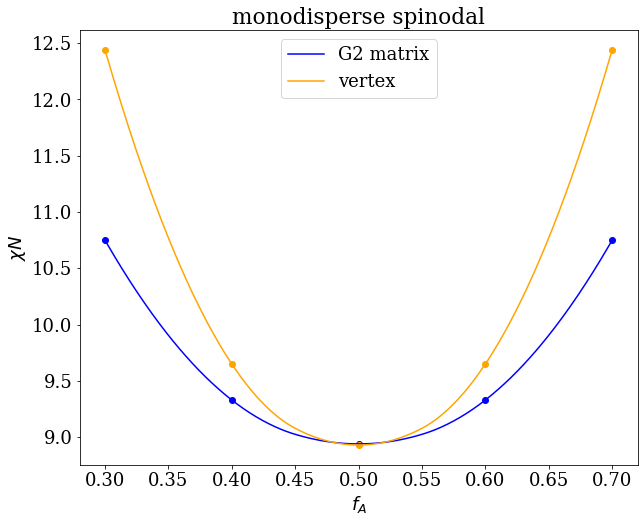

In [23]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)

new_x = np.arange(0.301, 0.7, 0.001)
ax.plot(new_x, matrixG2_spin_mono_interp(new_x), color = "blue", label = "G2 matrix")
ax.plot(new_x, vertex_spin_mono_interp(new_x), color = "orange", label = "vertex")

ax.scatter(FA_arr, spinodal_arr, color = "blue")
ax.scatter(FA_arr, spin_array_vertex*N_1, color = "orange")
plt.legend()
plt.title("monodisperse spinodal")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")

In [ ]:
#binary mix- boneheaded, non-generalized code
#TODO- make for a range of F_A
N_1 = 10.
FA_1 = 0.5
PHI_1 = 1.0

N_2 = 10.
FA_2 = 0.7
PHI_2 = 0.0

k0 = 1e-2
kf = 1e2
nk = 50

chi_range = np.arange(5.5, 20, 0.1)/N_1

k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)
# choose k based on sf_2 index

s2_1 = wlc_copoly.s2_wlc_diblock(k_vec, N_1, FA_1, dimensions=3, alpha_max=25)

s2_AA_1 = s2_1[0]
s2_AB_1 = s2_1[1]
s2_BB_1 = s2_1[2]

s2_2 = wlc_copoly.s2_wlc_diblock(k_vec, N_2, FA_2, dimensions=3, alpha_max=25)

s2_AA_2 = s2_2[0]
s2_AB_2 = s2_2[1]
s2_BB_2 = s2_2[2]

spinodal_arr = np.array([]) 

for chi in chi_range:
    print("chi: ", chi)
    chi_spin_bool = False #means spinodal has not been reached
    for k_ind in range(len(k_vec)):
        det_1 = s2_AA_1[k_ind] * s2_BB_1[k_ind] - s2_AB_1[k_ind]**2
        prefactor_1 = PHI_1/(det_1 * 2)[0]

        det_2 = s2_AA_2[k_ind] * s2_BB_2[k_ind] - s2_AB_2[k_ind]**2
        prefactor_2 = PHI_2/(det_2 * 2)[0]
        print("pref_2: ", prefactor_2)

        s2inv_AA_1 = s2_1[0][k_ind][0]*prefactor_1
        s2inv_AB_1 = s2_1[1][k_ind][0]*prefactor_1
        s2inv_BB_1 = s2_1[2][k_ind][0]*prefactor_1

        s2inv_AA_2 = s2_2[0][k_ind][0]*prefactor_2
        s2inv_AB_2 = s2_2[1][k_ind][0]*prefactor_2
        s2inv_BB_2 = s2_2[2][k_ind][0]*prefactor_2

        G2 = [[s2inv_BB_1, -s2inv_AB_1 + chi/2, 0, chi/2],[-s2inv_AB_1 + chi/2, s2inv_AA_1, chi/2, 0],[0, chi/2, s2inv_BB_2, -s2inv_AB_2 + chi/2],[chi/2, 0, -s2inv_AB_2 + chi/2, s2inv_AA_2]]
        determ = np.linalg.det(G2)
        print("determ: ", determ)
        if determ <= 0 :
            chi_spin_bool = True
            break
    print("spino?: ", chi_spin_bool)
    if chi_spin_bool == True:
        spinodal_arr = np.append(spinodal_arr, chi)
        break

In [ ]:
#TEST RUNS

In [140]:
%%time
#test if k identification is issue. Conclusion- it isn't!


#single component G2 matrix stability analysis

N_1 = 10.

# k0 = 1e-2
# kf = 1e2
# nk = 50
# k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

# FA_arr = np.arange(0.3, 0.71, 0.1)
# chi_range = np.arange(8, 12, .1)/N_1

spinodal_arr = np.array([]) 

for FA_1 in FA_arr:
    KS = spinodal(pset, N_1, FA_1)

    s2_1 = wlc_copoly.s2_wlc_diblock(KS, N_1, FA_1, dimensions=3, alpha_max=25)

    s2_AA_1 = s2_1[0][0][0]
    s2_AB_1 = s2_1[1][0][0]
    s2_BB_1 = s2_1[2][0][0]
    for chi in [0.]:#chi_range:
        
        
        chi_spin_bool = False #means spinodal has not been reached
        det_1 = s2_AA_1 * s2_BB_1 - s2_AB_1**2 #determinant of s2 matrix
        prefactor_1 = 1/(det_1*2) #1/2 from taylor expansion, which remains after performing gaussian integral
        
        s2inv_AA_1 = s2_AA_1*prefactor_1
        s2inv_AB_1 = s2_AB_1*prefactor_1
        s2inv_BB_1 = s2_BB_1*prefactor_1

        G2 = (1/N_1)*np.array([[s2inv_BB_1, -s2inv_AB_1 + 0.5*chi*N_1], [-s2inv_AB_1 + 0.5*chi*N_1, s2inv_AA_1]]) #single poly type

        eigvalues,eigvectors = np.linalg.eigh(G2)
        print("chi: ", chi)
        print("eigv: ", eigvalues)
        print("")
        min_eig = np.min(eigvalues)
        if min_eig <= 0:
            spinodal_arr = np.append(spinodal_arr,  chi*N_1)
            break
#         if eigvalues[0] < 0 and eigvalues[1] < 0:
#             chi_spin_bool = True
#             break

chi:  0.0
eigv:  [0.20945685 0.81548768]

chi:  0.0
eigv:  [0.23659584 0.53248752]

chi:  0.0
eigv:  [0.25731948 0.44643462]

chi:  0.0
eigv:  [0.23659584 0.53248752]

chi:  0.0
eigv:  [0.20945685 0.81548768]

Wall time: 1.03 s


In [137]:
spinodal_arr

array([], dtype=float64)

In [86]:
spin_array_vertex*N_1

array([12.4,  9.6,  8.9,  9.6, 12.4])

In [ ]:
%%time
#test to recreate 2x2 matrix that matches "Polymer semiflexibility induces..." 1x1 result pre incompressibility


#single component G2 matrix stability analysis

N_1 = 10.

# k0 = 1e-2
# kf = 1e2
# nk = 50
# k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

FA_arr = np.arange(0.3, 0.51, 0.05)
chi_range = np.arange(8, 20, .1)/N_1

spinodal_arr = np.array([]) 

for FA_1 in FA_arr:
    KS = spinodal(pset, N_1, FA_1)

    s2_1 = wlc_copoly.s2_wlc_diblock(KS, N_1, FA_1, dimensions=3, alpha_max=25)

    s2_AA_1 = s2_1[0][0][0]
    s2_AB_1 = s2_1[1][0][0]
    s2_BB_1 = s2_1[2][0][0]
    for chi in chi_range:
        
        
        chi_spin_bool = False #means spinodal has not been reached
        det_1 = s2_AA_1 * s2_BB_1 - s2_AB_1**2 #determinant of s2 matrix
        prefactor_1 = 1/(det_1) 

        s2inv_AA_1 = s2_AA_1*prefactor_1
        s2inv_AB_1 = s2_AB_1*prefactor_1
        s2inv_BB_1 = s2_BB_1*prefactor_1

        G2 = (1/N_1)*np.array([[s2inv_BB_1, s2inv_AB_1 + chi*N_1], [s2inv_AB_1 + chi*N_1, s2inv_AA_1]]) #single poly type

        eigvalues,eigvectors = np.linalg.eigh(G2)
        min_eig = np.min(eigvalues)
        if min_eig <= 0:
            spinodal_arr = np.append(spinodal_arr,  chi*N_1)
            break

In [ ]:
spinodal_arr

In [ ]:
%%time
#test to use Vertex-defined structure factors instead of wlcstat

#single component G2 matrix stability analysis

N_1 = 10.

# k0 = 1e-2
# kf = 1e2
# nk = 50
# k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

FA_arr = np.arange(0.3, 0.51, 0.05)
chi_range = np.arange(8, 20, .1)/N_1

spinodal_arr = np.array([]) 

for FA_1 in FA_arr:
    KS = spinodal(pset, N_1, FA_1)

    s2_1 = s2wlc(pset, N_1, FA_1, KS, sequence='all')

    s2_AA_1 = s2_1[0][0]*(1/N_1**2)
    s2_AB_1 = s2_1[1][0]*(1/N_1**2)
    s2_BB_1 = s2_1[1][1]*(1/N_1**2)
    for chi in chi_range:
        
        
        chi_spin_bool = False #means spinodal has not been reached
        det_1 = s2_AA_1 * s2_BB_1 - s2_AB_1**2 #determinant of s2 matrix
        prefactor_1 = 1/(det_1) #1/2 from taylor expansion, which remains after performing gaussian integral

        s2inv_AA_1 = s2_AA_1*prefactor_1
        s2inv_AB_1 = s2_AB_1*prefactor_1
        s2inv_BB_1 = s2_BB_1*prefactor_1

        G2 = (1/N_1)*np.array([[s2inv_BB_1, -s2inv_AB_1 + chi*N_1], [-s2inv_AB_1 + chi*N_1, s2inv_AA_1]]) #single poly type

        eigvalues,eigvectors = np.linalg.eigh(G2)
        min_eig = np.min(eigvalues)
        if min_eig <= 0:
            spinodal_arr = np.append(spinodal_arr,  chi*N_1)
            break

In [ ]:
spinodal_arr

In [97]:
%%time
#test to use Vertex-defined structure factors instead of wlcstat, copying GAMcalc solution

#single component G2 matrix stability analysis

N_1 = 10.

# k0 = 1e-2
# kf = 1e2
# nk = 50
# k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

FA_arr = np.arange(0.3, 0.71, 0.1)
chi_range = np.arange(8, 20, .1)/N_1

spinodal_arr = np.array([]) 

for FA_1 in FA_arr:
    KS = spinodal(pset, N_1, FA_1)

    s2_1 = s2wlc(pset, N_1, FA_1, KS, sequence='all')

    s2_AA_1 = s2_1[0][0]
    s2_AB_1 = s2_1[1][0]
    s2_BB_1 = s2_1[1][1]
    for chi in chi_range:
        
        
        chi_spin_bool = False #means spinodal has not been reached
        det_1 = s2_AA_1 * s2_BB_1 - s2_AB_1**2 #determinant of s2 matrix
        prefactor_1 = 1/(det_1) #1/2 from taylor expansion, which remains after performing gaussian integral

        s2inv_AA_1 = s2_AA_1*prefactor_1*N_1
        s2inv_AB_1 = -s2_AB_1*prefactor_1*N_1
        s2inv_BB_1 = s2_BB_1*prefactor_1*N_1

        G2 = (1/N_1)*(1/2)*np.array([[s2inv_BB_1, s2inv_AB_1 + chi], [s2inv_AB_1 + chi, s2inv_AA_1]]) #single poly type

        eigvalues,eigvectors = np.linalg.eigh(G2)
        min_eig = np.min(eigvalues)
        if min_eig <= 0:
            spinodal_arr = np.append(spinodal_arr,  chi*N_1)
            break

Wall time: 294 ms


In [98]:
spinodal_arr

array([10.8,  9.4,  9. ,  9.4, 10.8])

In [ ]:
s2inverse(pset, N_1, FA_1, KS)

In [ ]:
s2inv_AB_1

In [ ]:
spinodal_arr

In [ ]:
FA_1 = 0.3

In [ ]:
s2wlc(pset, N_1, FA_1, KS, sequence='all') #vertex

In [ ]:
wlc_copoly.s2_wlc_diblock(KS, N_1, FA_1, dimensions=3, alpha_max=25)

In [ ]:
#differ